In [1]:
import matplotlib.pyplot as plt

from ParametricGraphModels.ADC_SBM import *

In [2]:
# 1) ----------------- Set Params -----------------
community_sizes = [90, 140, 210, 160] # 4 communities; fixed
n = sum(community_sizes)  # number of nodes (observations)
b_communities = len(community_sizes)  # number of communities
m_features = 6  # number of numeric features; fixed
k_clusters = 6  # number of feature clusters; Overlap Scenario (over, under, match) 3,5,4
alpha, beta, lmbd = 2, 20, .5 # degree_correction params; fixed
br, wr = (.05, .1), (.4, .5) # assortative and dis-assortative

# 2) ------- Instantiate Class Object (Note: No graspy calles yet!) ---------
B = getB(m=b_communities,
         b_range=br,
         w_range=wr)  # get Connection Matrix

g = ADC_SBM(community_sizes=community_sizes, B=B)  # instantiate class

# 3) ----------------- Generate the actual Graph -----------------
g.correct_degree(alpha=alpha, beta=beta, lmbd=lmbd, distribution="exp")
g.gen_graph()

# 4) ----------------- Generate Node Features -----------------
# Generate "k" centroids with "m" features
centroids = np.random.multivariate_normal(np.repeat(0, m_features),  # mu
                                     getB(m_features,
                                          (0, 0),  # Covariance
                                          (3, 4.5)),  # Variance (relevant for cluster separation)
                                     k_clusters)  # n
# centroids will be an array of size kxm
# if the centroid variance is low and within-variance high,
# separation becomes harder, and easier if it's the other way around !

g.set_x(n_c=k_clusters,  # number of clusters
        mu=[tuple(point) for point in centroids],  # k tuple of coordinates in m-dimensional space
        sigma=[getB(m_features, (0, 0), # Covariance
                                (0.5, 1)) # Variance (relevant for cluster separation)
               for _ in range(k_clusters)],
        # similar covariance matrix for each centroid
        #w=np.random.dirichlet(np.ones(k_clusters), size=1).flatten()
        w=np.full(k_clusters, n/k_clusters, dtype=np.int64)
        )

In [3]:
# 5) ----------------- Generate Targets -----------------
ny = 5  # number of target classes; fixed
nf = m_features + 1 + b_communities # number of relevant features (community and degree considered!)

omega = getW(ny, b_communities, m_features, w_degree=0, w_x= 0, w_com=10)
g.set_y(task="multiclass", weights=omega, distribution="normal", eps=.01)

In [33]:
# g.rich_plot_graph(ns=25,wdth=.2,alph=.05)

In [32]:
xlin = np.linspace(0, 10, num=100)
res = np.zeros((b_communities, 100))
for i,v in enumerate(xlin):
    omega = getW(ny, b_communities, m_features, w_degree=0, w_x= 0, w_com=v)
    g.set_y(task="multiclass", weights=omega, distribution="normal", eps=.01)
    df = g.purity(group_by="Community", metric="gini", plot_it=False)
    res[:,i] = df.to_numpy()
    #print(df.to_numpy())

Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric selected:  gini
Metric sele

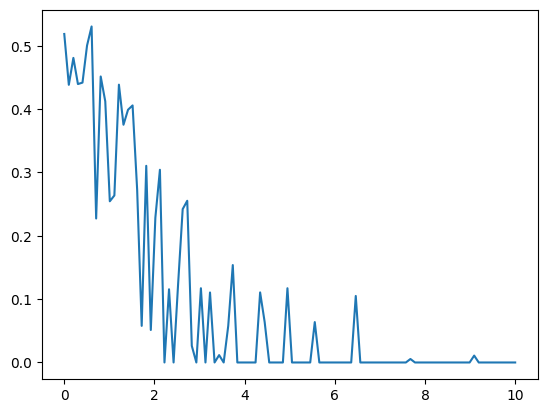

In [33]:
plt.plot(xlin, res.mean(axis=0))
plt.show()